# Bitcoin EMA, VOL, RSI Strategy

- This is one of the simplest trading strategies
- Direction 
    - EMA + VEGAS 
- Singals
    - RIS + Vol Spike

# Set up

Set up Trading Strategy data client.


In [1]:
from tradeexecutor.utils.notebook import setup_charting_and_output
from tradingstrategy.client import Client
from tradeexecutor.utils.notebook import setup_charting_and_output, OutputMode

client = Client.create_jupyter_client()

# Set up drawing charts in interactive vector output mode.
# This is slower. See the alternative commented option below.
# setup_charting_and_output(OutputMode.interactive)

# Set up rendering static PNG images.
# This is much faster but disables zoom on any chart.
setup_charting_and_output(OutputMode.static, image_format="png", width=1500, height=1000)


Started Trading Strategy in Jupyter notebook environment, configuration is stored in /home/vscode/.tradingstrategy


# Parameters

- Strategy parameters define the fixed and grid searched parameters

In [84]:
from tradingstrategy.chain import ChainId
import datetime

from tradeexecutor.strategy.default_routing_options import TradeRouting
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.parameters import StrategyParameters


class Parameters:
    """Parameteres for this strategy.

    - Collect parameters used for this strategy here

    - Both live trading and backtesting parameters
    """

    id = "bitcoin-ma" # Used in cache paths

    cycle_duration = CycleDuration.cycle_15m
    candle_time_bucket = TimeBucket.m15
    allocation = 0.98   

    ma_length = 50  # What's our moving average bar threshold
    

    #
    # Live trading only
    #
    chain_id = ChainId.ethereum
    routing = TradeRouting.default  # Pick default routes for trade execution
    required_history_period = datetime.timedelta(hours=200)

    #
    # Backtesting only
    #
    backtest_start = datetime.datetime(2024, 1, 1)
    backtest_end = datetime.datetime(2025, 3, 1)
    backtest_trading_fee = 0.0005  # Override the default Binance data trading fee and assume we can trade 5 BPS fee on WMATIC-USDC on Polygon on Uniswap v3
    initial_cash = 10_000


parameters = StrategyParameters.from_class(Parameters)  # Convert to AttributedDict to easier typing with dot notation



# Trading pairs and market data

- Set up our trading pairs
- Load historical market data for backtesting
- We use Binance CEX data so we have longer history to backtest
- If you would like to use DEX data, uncomment the second cell below. Note that your backtest will have to start later since DEX data is smaller.
Also profitability will be affected due to higher fees in this case. 

In [85]:
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse, load_partial_data
from tradingstrategy.client import Client
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.utils.binance import create_binance_universe
from tradeexecutor.strategy.universe_model import UniverseOptions

# List of trading pairs we use in the backtest
# In this backtest, we use Binance data as it has more price history than DEXes
trading_pairs = [
    (ChainId.centralised_exchange, "binance", "BTC", "USDT"),
]

def create_trading_universe(
    timestamp: datetime.datetime,
    client: Client,
    execution_context: ExecutionContext,
    universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    """Create the trading universe.

    - For live trading, we load DEX data

    - We backtest with Binance data, as it has more history
    """

    # Backtesting - load Binance data
    strategy_universe = create_binance_universe(
        [f"{p[2]}{p[3]}" for p in trading_pairs],
        candle_time_bucket=Parameters.candle_time_bucket,
        start_at=universe_options.start_at,
        end_at=universe_options.end_at,
        trading_fee_override=Parameters.backtest_trading_fee,
    )
    return strategy_universe


strategy_universe = create_trading_universe(
    None,
    client,
    notebook_execution_context,
    UniverseOptions.from_strategy_parameters_class(Parameters, notebook_execution_context)
)


Loaded candlestick data for BTCUSDT from cache:   0%|          | 0/1 [00:00<?, ?it/s]

/trading-strategy/tradeexecutor/utils/binance.py:110: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/trading-strategy/tradeexecutor/strategy/pandas_trader/alternative_market_data.py:125: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/trading-strategy/tradeexecutor/strategy/pandas_trader/alternative_

# Indicators

- We use `pandas_ta` Python package to calculate technical indicators
- These indicators are precalculated and cached on the disk

In [ ]:
import pandas as pd
import pandas_ta

from tradeexecutor.analysis.regime import Regime
from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSet, IndicatorSource
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradingstrategy.utils.groupeduniverse import resample_candles


def create_indicators(
    timestamp: datetime.datetime | None,
    parameters: StrategyParameters,
    strategy_universe: TradingStrategyUniverse,
    execution_context: ExecutionContext
):
    indicators = IndicatorSet()

    # https://github.com/twopirllc/pandas-ta/blob/main/pandas_ta/volatility/atr.py
    # Add Moving Averages
    indicators.add("ema_20", pandas_ta.ema, {"length": 20}, IndicatorSource.close_price)
    indicators.add("ema_50", pandas_ta.ema, {"length": 50}, IndicatorSource.close_price)
    indicators.add("ema_200", pandas_ta.ema, {"length": 200}, IndicatorSource.close_price)
    indicators.add("vegas_ema1", pandas_ta.ema, {"length": 144}, IndicatorSource.close_price)  
    indicators.add("vegas_ema2", pandas_ta.ema, {"length": 169}, IndicatorSource.close_price)  
    indicators.add("vegas_ema3", pandas_ta.ema, {"length": 575}, IndicatorSource.close_price)  
    indicators.add("vegas_ema4", pandas_ta.ema, {"length": 676}, IndicatorSource.close_price)  
    

    # # Add RSI
    indicators.add("rsi", pandas_ta.rsi, {"length": 14}, IndicatorSource.close_price)

    # Add Volume Spike
    def vol_spike(volume: pd.Series):
        vol_avg = volume.rolling(window=20).mean()
        return volume > (1.5 * vol_avg)
    
    indicators.add("vol_spike", vol_spike, {}, IndicatorSource.ohlcv)


    # Add Slope Calculation for Vegas EMAs
    def ema_slope(indicator_set, ema_name: str, n: int):
        ema_series = indicator_set.get_indicator_value(ema_name)
        return (ema_series - ema_series.shift(n)) / n

    indicators.add(
        "slope_ema_576",
        ema_slope,
        {"ema_name": "ema_576", "n": 20},
        IndicatorSource.dependencies_only_per_pair  
    

    # # Add slope calculations
    # indicators.add(
    #     "slope_ema_576", 
    #     ema_slope, 
    #     {"ema_name": "ema_576", "n": 20}, 
    #     IndicatorSource.strategy_universe 
    # )
    # indicators.add(
    #     "slope_ema_676", 
    #     ema_slope, 
    #     {"ema_name": "ema_676", "n": 50}, 
    #     IndicatorSource.indicator
    # )
    return indicators


# Trading algorithm

- Describe out trading strategy as code

In [89]:
from tradeexecutor.state.visualisation import PlotKind
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pandas_trader.strategy_input import StrategyInput

import pandas as pd
import pandas_ta as ta
import datetime
from tradeexecutor.strategy.pandas_trader.strategy_input import StrategyInput

def decide_trades(
    input: StrategyInput,
) -> list[TradeExecution]:

    # 
    # Decidion cycle setup.
    # Read all variables we are going to use for the decisions.
    #
    parameters = input.parameters
    position_manager = input.get_position_manager()
    state = input.state
    timestamp = input.timestamp
    indicators = input.indicators
    strategy_universe = input.strategy_universe

    pair = strategy_universe.get_single_pair()
    cash = position_manager.get_current_cash()

    #
    # Indicators
    #

    
    close_price = indicators.get_price()
    ema50 = indicators.get_indicator_value("ema_50")
    ema200 = indicators.get_indicator_value("ema_200")
    rsi = indicators.get_indicator_value("rsi")
    vol_spike = indicators.get_indicator_value("vol_spike")

    vegas_ema1 = indicators.get_indicator_value("vegas_ema1")
    vegas_ema2 = indicators.get_indicator_value("vegas_ema2")
    vegas_ema3 = indicators.get_indicator_value("vegas_ema3")
    vegas_ema4 = indicators.get_indicator_value("vegas_ema4")


    print("vol_spike", vol_spike,"vegas_ema4" , vegas_ema4)
    if  ema200 is None or vegas_ema4 is None:
        return []

   
    # === Compute Vegas Tunnel Slope ===
    # n = 20  # Slope window size
    # slope_ema576 =  indicators.get_indicator_value("slope_ema_576")
    # slope_ema676 =  indicators.get_indicator_value("slope_ema_576")

    # slope_threshold = 0.1
    # buy_slope = (slope_ema576 >= slope_threshold) & (slope_ema676 >= slope_threshold)
    # short_slope = (slope_ema576 <= -slope_threshold) & (slope_ema676 <= -slope_threshold)

    # === Trend Confirmation ===
    long_trend = (ema50 > ema200) & (vegas_ema3 > vegas_ema4) # & buy_slope
    short_trend = (ema50 < ema200) # & short_slope


    # # === Price Distance from Vegas Tunnel ===
    vegas_mid = (vegas_ema1 + vegas_ema2) / 2
    vegas_distance = abs(close_price - vegas_mid)
    vegas_range = abs(vegas_ema2 - vegas_ema1)

    tunnel_width = abs(vegas_ema3 - vegas_ema4)
    upper_bound = vegas_ema3 + 4 * tunnel_width
    lower_bound = vegas_ema4 - 4 * tunnel_width

    valid_trade_zone = vegas_distance < (vegas_range * 4)  # 4x Rule


    # # === Trading Signals ===
    buy_signal =  long_trend & (rsi <= 30) & vol_spike & (close_price < upper_bound) & valid_trade_zone
    sell_signal = short_trend & (rsi >= 70) & vol_spike & (close_price > lower_bound) & valid_trade_zone

    #
    # Trading logic
    #

    trades = []

    # Check for open condition - is the price breaking out
    #

    print('buy signal', buy_signal, "short signal:", sell_signal)
    
    if not position_manager.is_any_open():
        if buy_signal:
            trades += position_manager.open_spot(
                pair,
                value=cash * parameters.allocation,                
            )
    else:        
        if sell_signal:
            trades += position_manager.close_all()



    # Visualisations
    #

    return trades  # Return the list of trades we made in this cycle

# Backtest

- Run the backtest

In [90]:
from tradeexecutor.backtest.backtest_runner import run_backtest_inline

result = run_backtest_inline(
    name=parameters.id,
    engine_version="0.5",
    decide_trades=decide_trades,
    create_indicators=create_indicators,
    client=client,
    universe=strategy_universe,
    parameters=parameters,
    strategy_logging=False,
)

state = result.state

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

Reading cached indicators ema_20, ema_50, ema_200, vegas_ema1, vegas_ema2, vegas_ema3, vegas_ema4, rsi, vol_sp…

Using indicator cache /home/vscode/.cache/indicators/centralised-exchange_15m_BTC-USDT_2024-01-01-2025-03-01_nff


  0%|          | 0/36720000 [00:00<?, ?it/s]

vol_spike False vegas_ema4 None
vol_spike False vegas_ema4 None
vol_spike False vegas_ema4 None
vol_spike False vegas_ema4 None
vol_spike False vegas_ema4 None
vol_spike False vegas_ema4 None
vol_spike False vegas_ema4 None
vol_spike False vegas_ema4 None
vol_spike False vegas_ema4 None
vol_spike False vegas_ema4 None
vol_spike False vegas_ema4 None
vol_spike False vegas_ema4 None
vol_spike False vegas_ema4 None
vol_spike False vegas_ema4 None
vol_spike False vegas_ema4 None
vol_spike False vegas_ema4 None
vol_spike False vegas_ema4 None
vol_spike False vegas_ema4 None
vol_spike False vegas_ema4 None
vol_spike False vegas_ema4 None
vol_spike False vegas_ema4 None
vol_spike False vegas_ema4 None
vol_spike False vegas_ema4 None
vol_spike False vegas_ema4 None
vol_spike False vegas_ema4 None
vol_spike False vegas_ema4 None
vol_spike False vegas_ema4 None
vol_spike False vegas_ema4 None
vol_spike False vegas_ema4 None
vol_spike False vegas_ema4 None
vol_spike False vegas_ema4 None
vol_spik

# Equity curve

- Equity curve shows how your strategy accrues value over time
- A good equity curve has a stable ascending angle
- Benchmark against Bitcoin buy and hold
- Use logarithmic Y axis because of the vast increase in prices and to better compare results towards the end of the backtest period

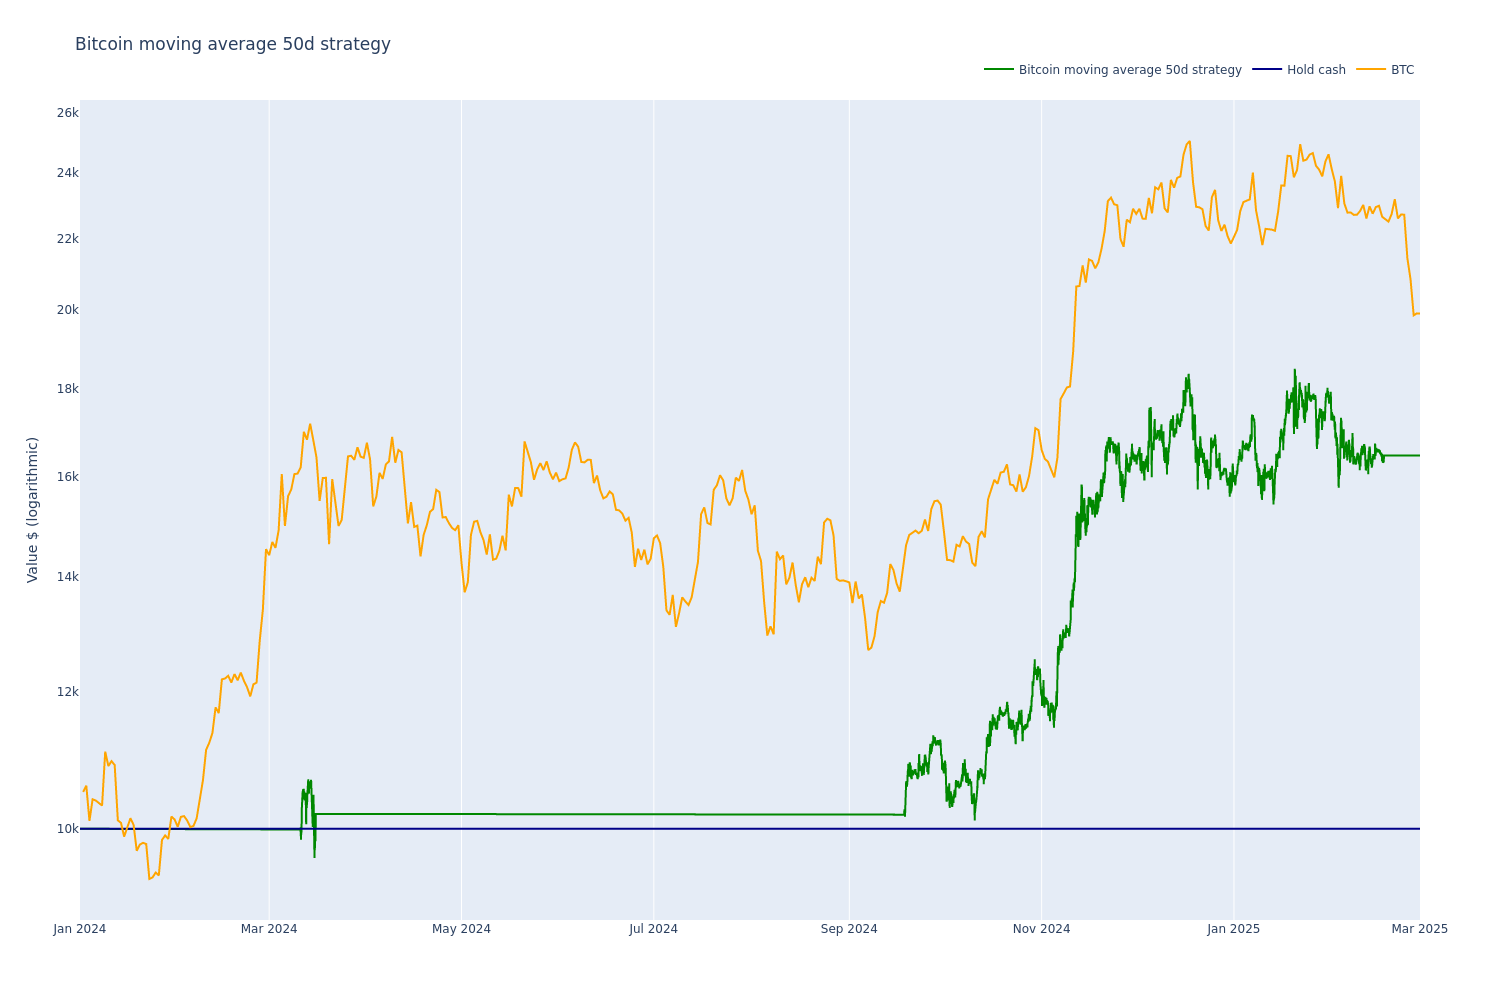

In [ ]:
import pandas as pd
from tradeexecutor.analysis.multi_asset_benchmark import get_benchmark_data
from tradeexecutor.visual.benchmark import visualise_equity_curve_benchmark

benchmark_indexes = get_benchmark_data(
    strategy_universe,
    cumulative_with_initial_cash=state.portfolio.get_initial_cash()
)

fig = visualise_equity_curve_benchmark(
    name="Bitcoin EMA VOL RSI strategy",
    state=state,
    all_cash=state.portfolio.get_initial_cash(),
    benchmark_indexes=benchmark_indexes,
    height=800,
    log_y=True,
)

fig.show()

# Technical indicator and trade visualisation

- Draw the technical indicators we filled in in `decide_trades()`
- Show the made trades on the price chart for a single trading pair
- You need to zoom in to see the bollinger bands, as the default chart width is full multi-year study.
  However the default notebook chart mode is static images, as interactive images are a bit slow on Github Codespaces.

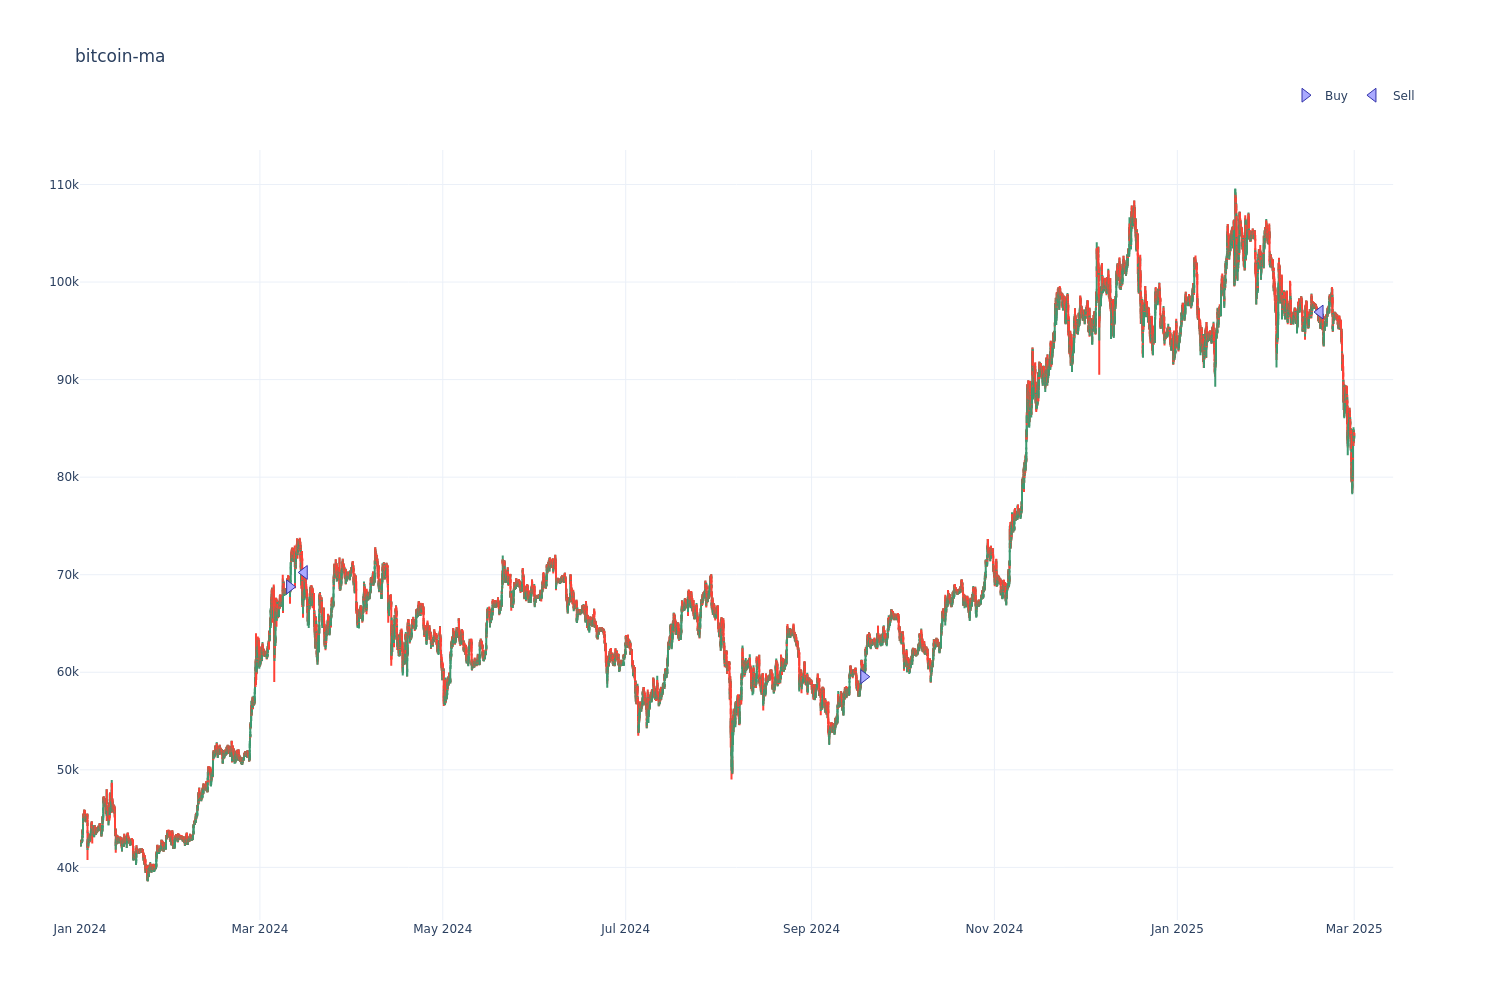

In [96]:
from tradeexecutor.visual.single_pair import visualise_single_pair
from tradingstrategy.charting.candle_chart import VolumeBarMode

start_at, end_at = state.get_strategy_start_and_end()   # Limit chart to our backtesting range

figure = visualise_single_pair(
    state,
    execution_context=notebook_execution_context,
    candle_universe=strategy_universe.data_universe.candles,
    start_at=start_at,
    end_at=end_at,
    volume_bar_mode=VolumeBarMode.hidden,
    volume_axis_name="Volume (USD)",
    height = 1000,
)

figure.show()

# Performance metrics

- Display portfolio performance metrics
- Compare against buy and hold matic using the same initial capital

In [94]:
from tradeexecutor.analysis.multi_asset_benchmark import compare_strategy_backtest_to_multiple_assets

compare_strategy_backtest_to_multiple_assets(
    state,
    strategy_universe,
    display=True,
)

Strategy                  BTC
Start Period                        2024-01-01           2024-01-01
End Period                          2025-02-28           2025-02-28
Risk-Free Rate                            0.0%                 0.0%
Time in Market                           38.0%                84.0%
Cumulative Return                        64.6%               23.94%
CAGR﹪                                   34.47%                13.6%
Sharpe                                    1.69                 0.63
Prob. Sharpe Ratio                      97.37%                75.4%
Smart Sharpe                              1.64                 0.62
Sortino                                   2.99                 0.96
Smart Sortino                             2.91                 0.94
Sortino/√2                                2.11                 0.68
Smart Sortino/√2                          2.06                 0.66
Omega                                     1.49                 1.49
Max Drawdown                            -13.1%              -26.09%
Longest DD Days                            189                  237
Volatility (ann.)                       27.57%               45.03%
Calmar                                    2.63                 0.52
Skew                                      1.54                 0.51
Kurtosis                                 10.48                 3.01
Expected Daily                           0.12%                0.05%
Expected Monthly                         3.62%                1.54%
Expected Yearly                          28.3%               11.33%
Kelly Criterion                         17.77%                2.15%
Risk of Ruin                              0.0%                 0.0%
Daily Value-at-Risk                     -2.25%                -3.8%
Expected Shortfall (cVaR)               -2.25%                -3.8%
Max Consecutive Wins                         7                    9
Max Consecutive Losses                       6                    6
Gain/Pain Ratio                           0.49                  0.1
Gain/Pain (1M)                            7.35                 0.63
Payoff Ratio                              1.26                 1.05
Profit Factor                             1.49                  1.1
Common Sense Ratio                        2.12                 1.12
CPC Index                                 1.02                 0.58
Tail Ratio                                1.42                 1.02
Outlier Win Ratio                         9.98                 4.37
Outlier Loss Ratio                        2.38                  2.6
MTD                                     -5.18%              -19.13%
3M                                       0.88%               -8.51%
6M                                      61.36%               34.51%
YTD                                      3.63%               -8.91%
1Y                                       64.6%               23.94%
3Y (ann.)                               34.47%                13.6%
5Y (ann.)                               34.47%                13.6%
10Y (ann.)                              34.47%                13.6%
All-time (ann.)                         34.47%                13.6%
Best Day                                10.13%               11.67%
Worst Day                               -5.27%               -8.48%
Best Month                              36.28%                34.4%
Worst Month                             -5.18%              -19.13%
Best Year                               58.84%               36.06%
Worst Year                               3.63%               -8.91%
Avg. Drawdown                           -3.35%               -6.99%
Avg. Drawdown Days                          19                   37
Recovery Factor                           4.14                 1.27
Ulcer Index                               0.04                 0.11
Serenity Index                            2.19                 0.37
Avg. Up Month             

# Trading statistics

- Display summare about made trades

In [95]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)
summary = analysis.calculate_summary_statistics()
display(summary.to_dataframe())

# Rolling Sharpe

- See how the six months rolling Sharpe ratio changes over time

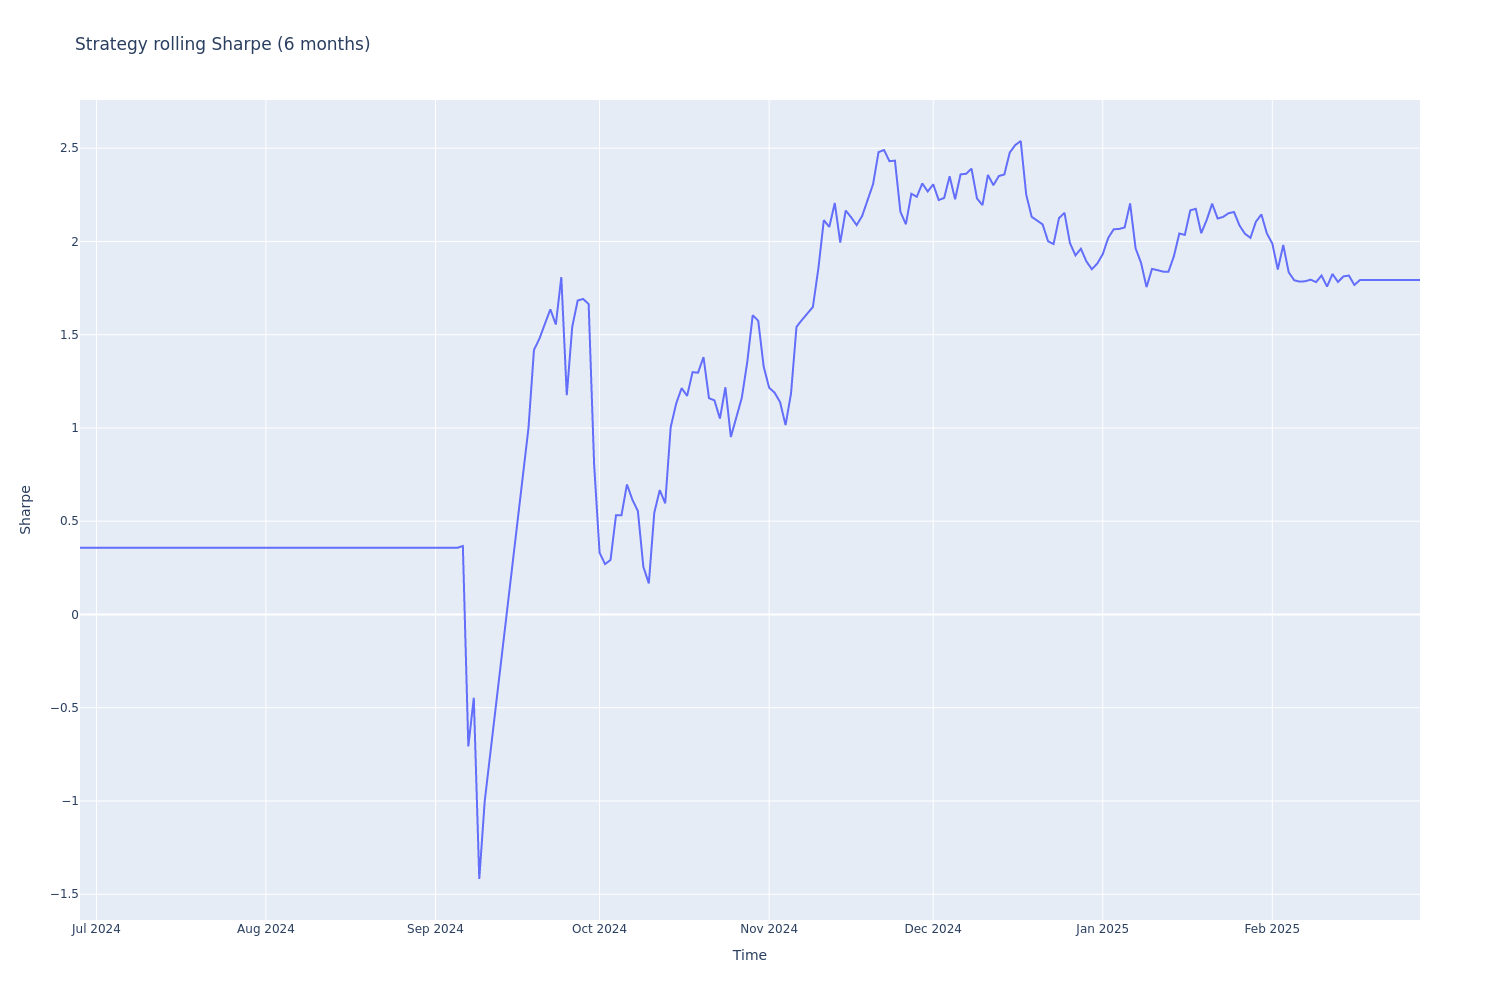

In [97]:
import plotly.express as px

from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.visual.equity_curve import calculate_rolling_sharpe

equity = calculate_equity_curve(state)
returns = calculate_returns(equity)

rolling_sharpe = calculate_rolling_sharpe(
    returns,
    freq="D",
    periods=180,
)

fig = px.line(rolling_sharpe, title='Strategy rolling Sharpe (6 months)')
fig.update_layout(showlegend=False)
fig.update_yaxes(title="Sharpe")
fig.update_xaxes(title="Time")
fig.show()